In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import git
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import subprocess
import sys

from git import Repo
from unidiff import PatchSet

from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from src import loading
from src import predictor
from src import preprocessing
from src import visualization
from src.reorderer import *
from src.reordering_analyzer import ReorderingAnalyzer


# Structure

This notebook is seperated into 3 main sections

## 1. [Visualization](#Visualization)
    
Making the mutation testing data gathered visible and exploring the test suites visually.

## 2. [Prediction](#Prediction)

Preparing the data for predicting failing tests, and exploring features and different models.

## 3. [Reordering](#Reordering)

Using the prepared data for a dive into Test Case Reordering, using both binary classifiers from before, as other methods and comparing there results.

# What data are we working with?

Our starting point is mutation testing data generated by [Mutester](https://github.com/XPerianer/CRM2020), a tool that was developed for exactly this task.
Also have a look at the [midterm presentation slides](../presentation/midterm.pdf) for more information about how and why we gathered data.

In [3]:
# It is possible to use the sparsify flag, if you want to test if models throw errors / for a quick check.
# USE WITH CAUTION: This is by no means designed to give an appropriate / random sample.
# For long running cells, I also tried to split the visualization with the resource intense part, so the notebook can run overnight, and then the output will be generated when you reconnect.
datasets = loading.load_datasets({
    'Flask': 'data/flask_full.pkl',
    'Jinja': 'data/jinja_full.pkl',
    'Httpie': 'data/httpie_full.pkl',
    'Docopt': 'data/docopt_full.pkl'
}, sparsify=False)    

### The mutants_and_tests data structure
The main structure of such a datasets is that for each mutant, with it's respective `mutant_id`, and every test case, with it's respective `test_id`,
there is a row in the dataset, recording the outcome of the test, and additional information, like how long the test took, what files where touched, etc.
The dataframe index we will use in the whole notebook will always be the same. That's how we can find back datapoints later if we want to.

In [20]:
# Have a quick look here:
datasets['Flask'].head()

,mutant_id,contains_branch_mutant,contains_equality_comparison_mutant,contains_loop_mutant,contains_math_operands_mutant,current_line,line_number_changed,modified_file_path,modified_method,previous_line,...,call_outcome,call_duration,teardown_outcome,teardown_duration,contains_branch_execution,contains_loop_execution,contains_math_operands_execution,contains_equality_comparison_execution,edit_distance_method_name_test_name,edit_distance
0,1977.0,1,0,0,1,"key = ""XX mXX""",175.0,src/flask/json/tag.py,TagMarkup,,...,True,0.000806,True,0.000296,False,False,True,False,9,22
1,1977.0,1,0,0,1,"key = ""XX mXX""",175.0,src/flask/json/tag.py,TagMarkup,,...,True,0.000364,True,0.000240,False,True,False,False,9,36
2,1977.0,1,0,0,1,"key = ""XX mXX""",175.0,src/flask/json/tag.py,TagMarkup,,...,True,0.000237,True,0.000219,False,True,False,False,9,38
3,1977.0,1,0,0,1,"key = ""XX mXX""",175.0,src/flask/json/tag.py,TagMarkup,,...,True,0.000934,True,0.000243,False,False,False,True,9,35
4,1977.0,1,0,0,1,"key = ""XX mXX""",175.0,src/flask/json/tag.py,TagMarkup,,...,True,0.000288,True,0.000238,False,False,False,True,9,33


# Visualization
## Visualising Data generated by Mutation testing

In the beginning of the project, I tried to get a glimpse of the generated data by trying out different visualizations,
the most basic beeing the covariance matrix, and then two different approaches.

# Correlation Matrixes

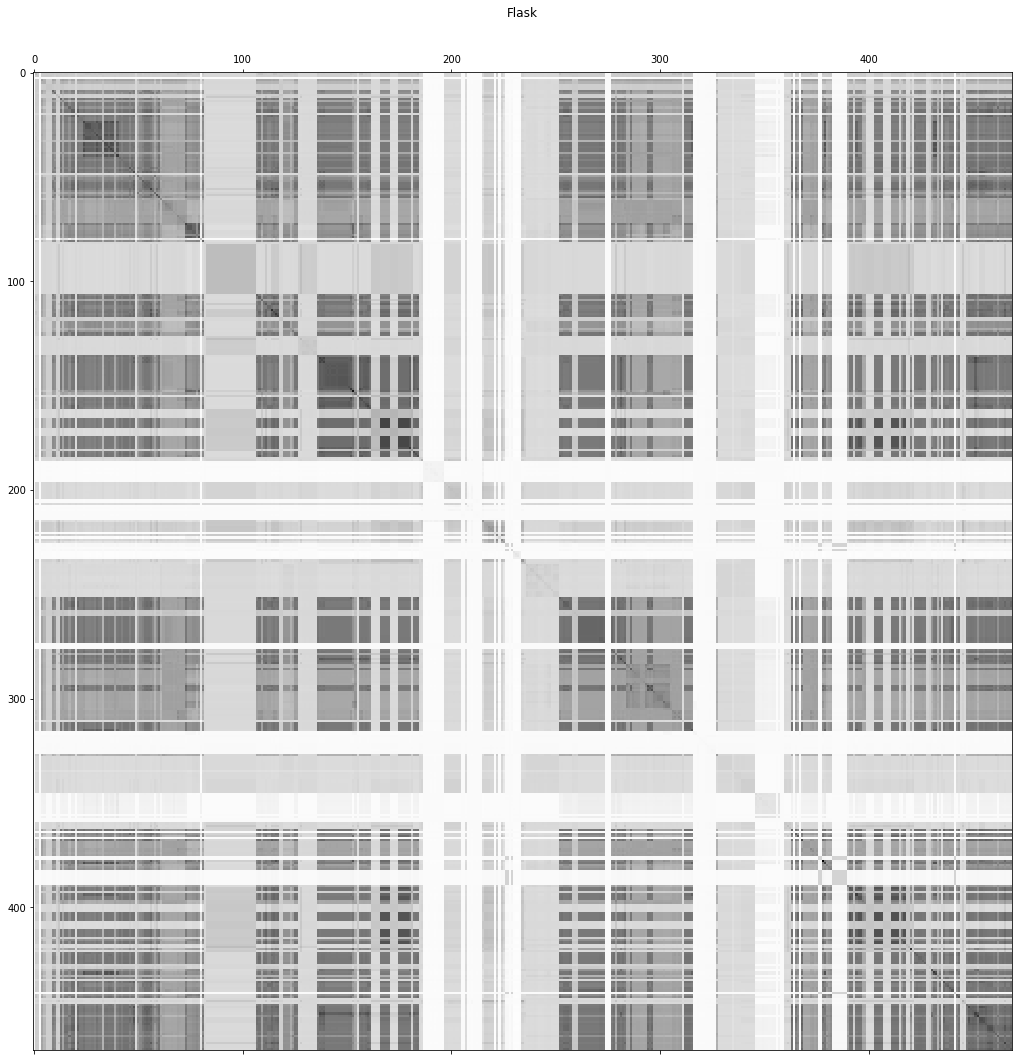

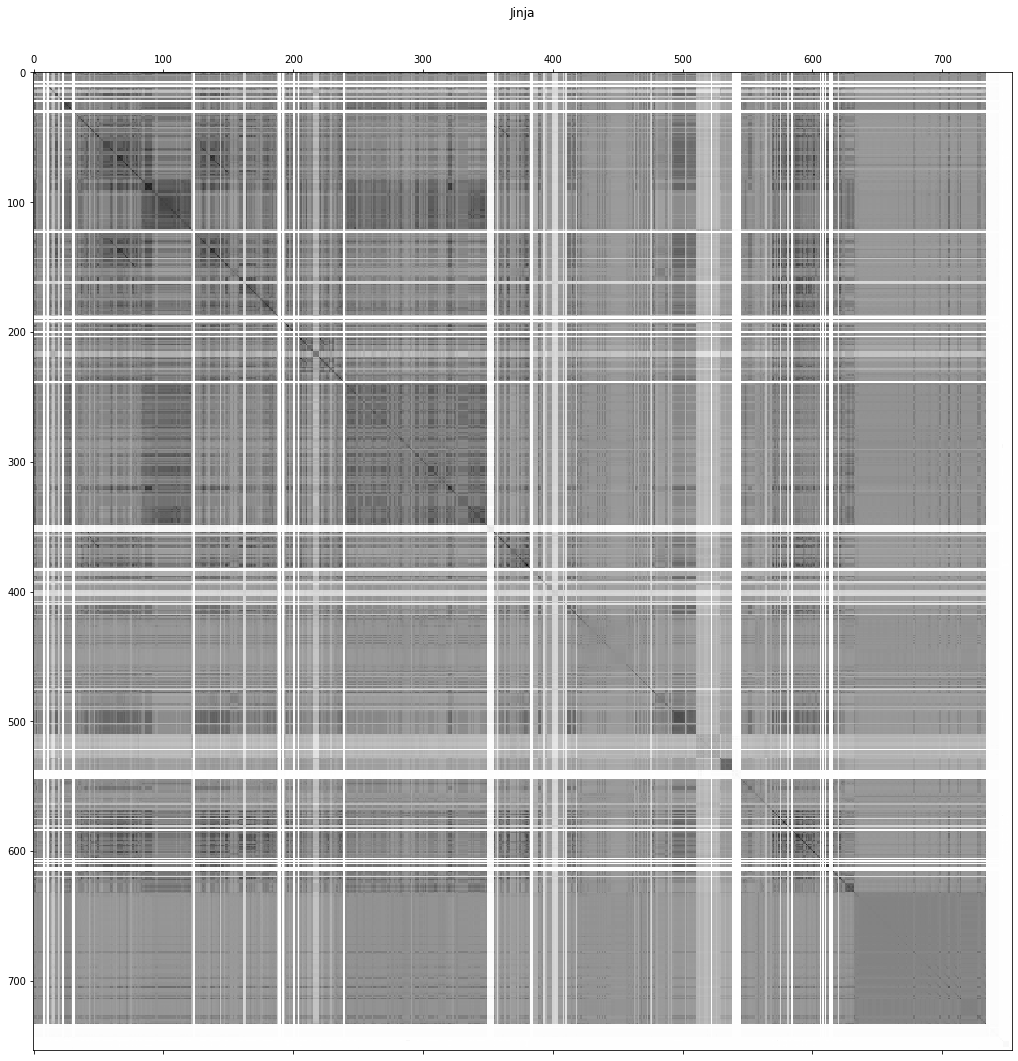

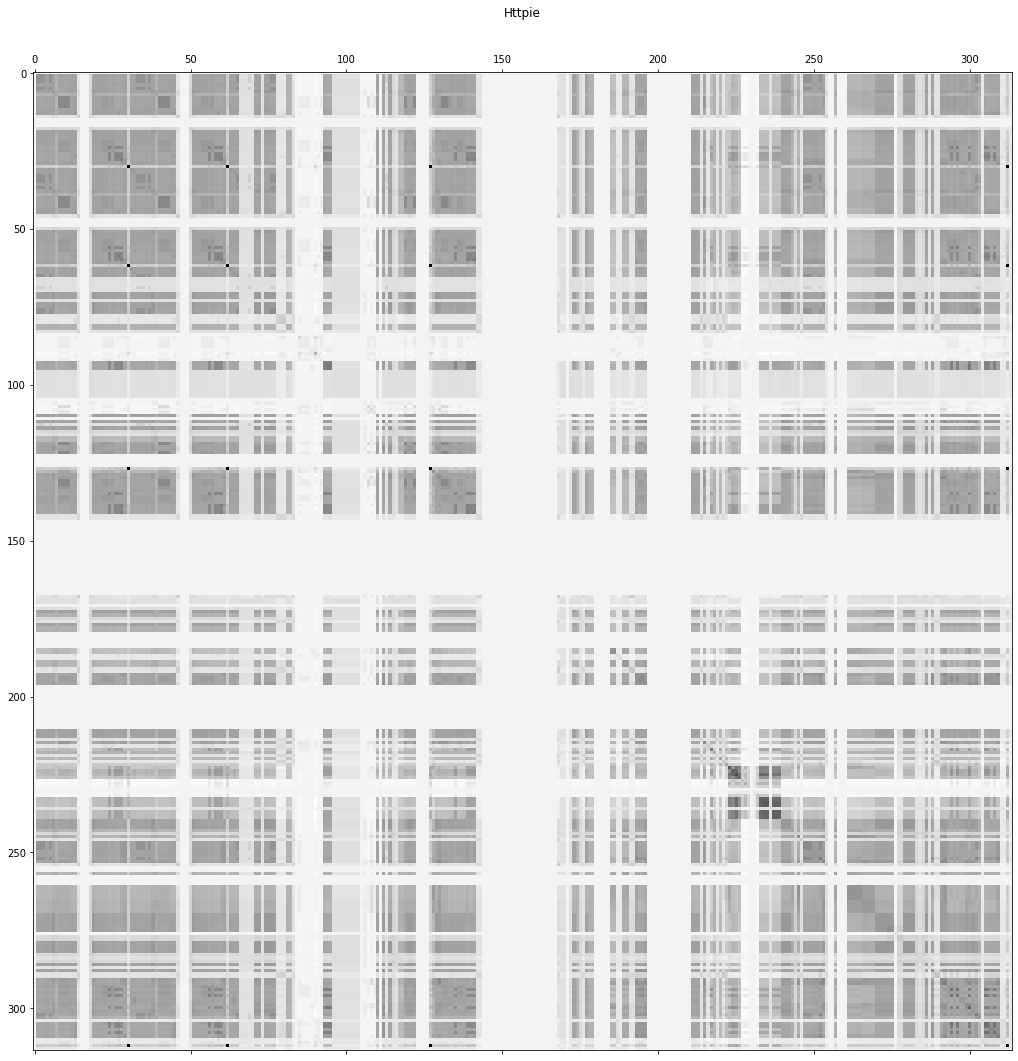

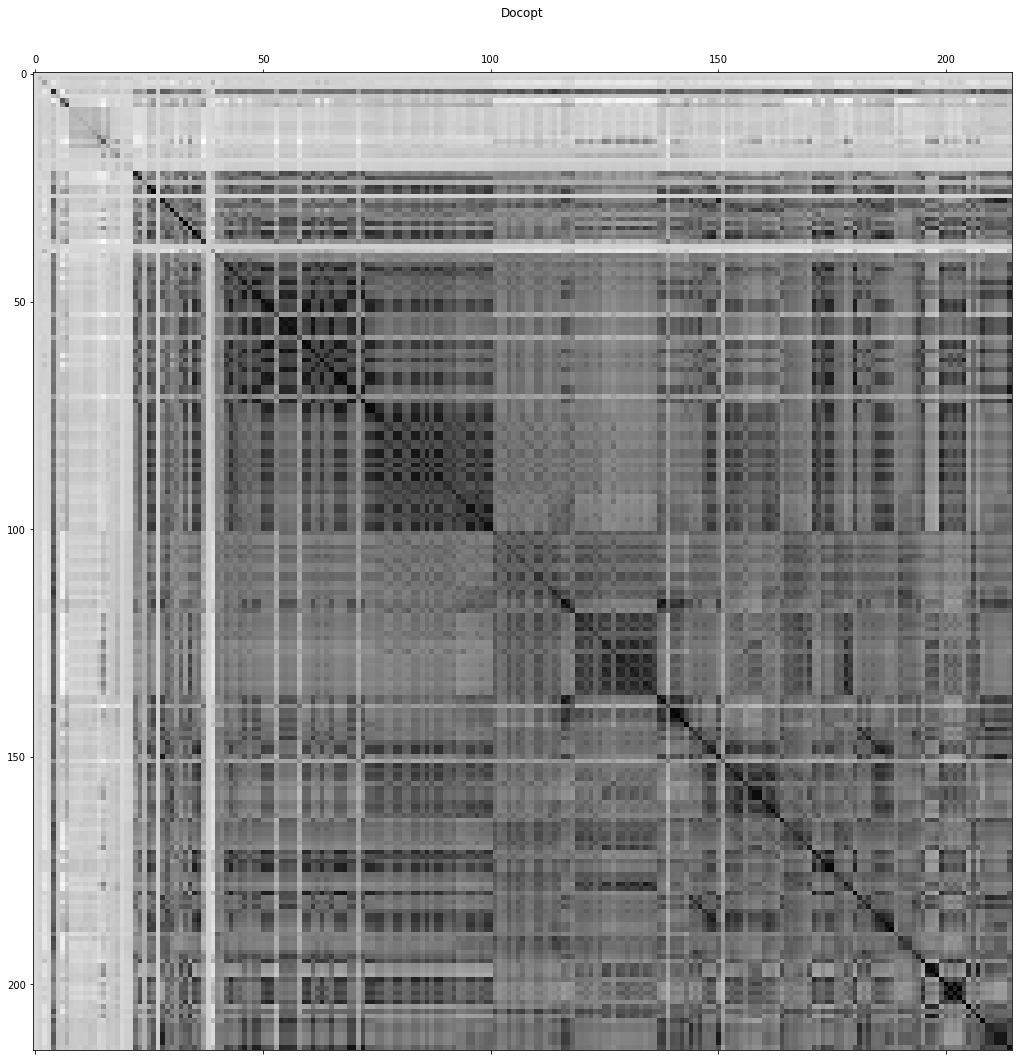

In [4]:
for name, mutants_and_tests in datasets.items():
    visualization.plot_covariance_matrix(name, mutants_and_tests)

An interesting aspect is also how often tests fail in general, and how the distribution is through the datasets:

What we can observe is that while flask and httpie have a very low number of often failing tests, jinja and docopt have a wider variety of tests failing.
We can see the behavoior also in the covariance matrixes, that are a lot lighter for flask and httpie, due to less covariance in tests often failing together.

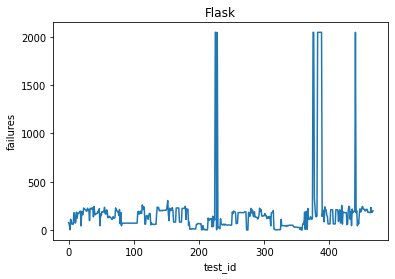

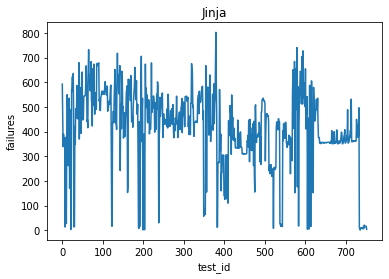

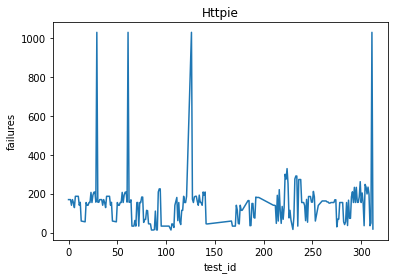

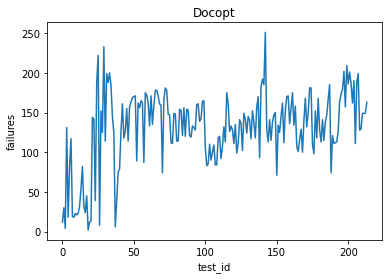

In [5]:
for name, data in datasets.items():
    visualization.plot_failure_histogram(name,data)

Later, it will also be interesting how the failure of the test correlates to the average duration of the test. You can see this in these scatter plots:


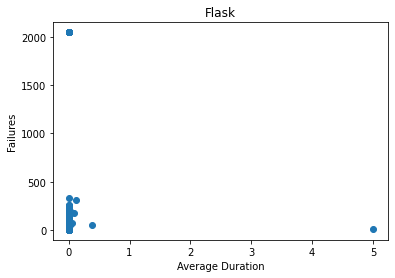

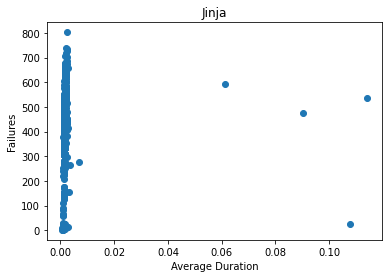

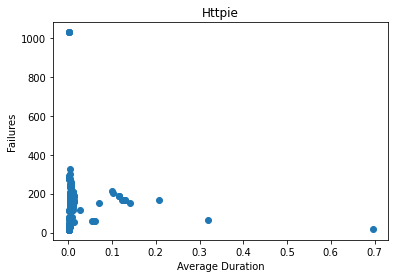

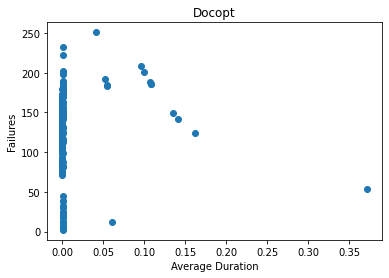

In [6]:
for name, data in datasets.items():
    visualization.plot_failures_vs_duration(name,data)

# Hierarchical Plot of tests


To try to get even more insight into the different datasets, I tried to come up with my own domain specific visualization, that builds on top of the failure histogram.

We print one dot for every test, with the following properties:
x axis = average of ids of changed line (mutant_ids) that make this test fail
y axis = number of mutants that make this test fail

So for example a unit test should be relatively wide down, since it should not fail on too many mutants.

To show the 'spread' of which mutant_ids made which tests fail, we draw an arrow from (mutant_id, 0) to (x,y) of the test, iff mutant_id makes the test fail

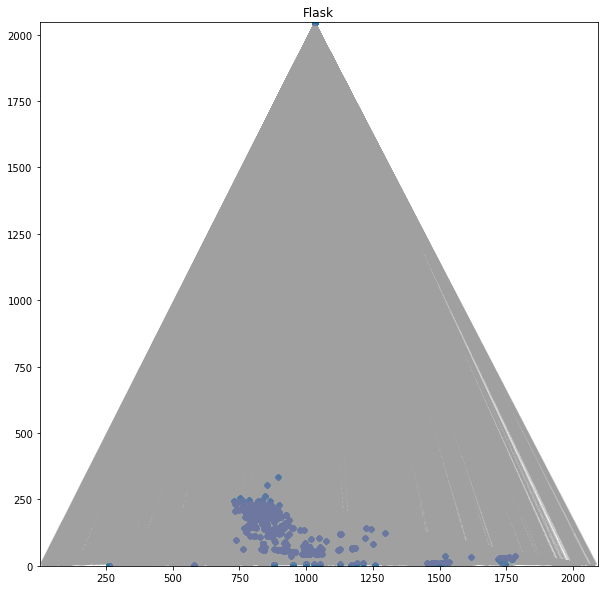

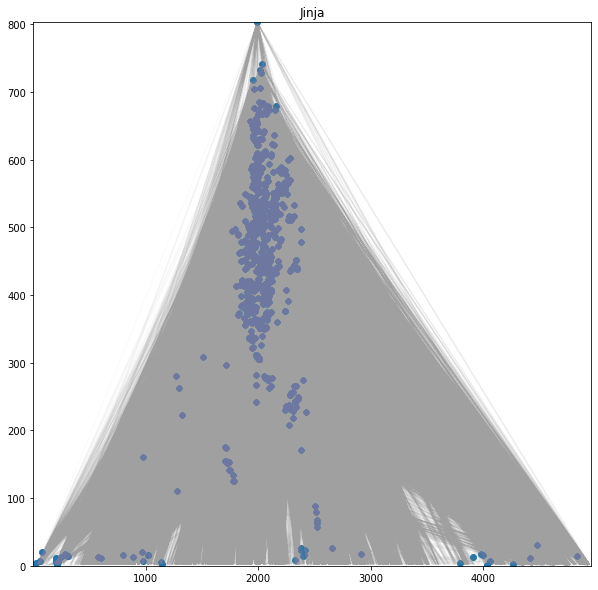

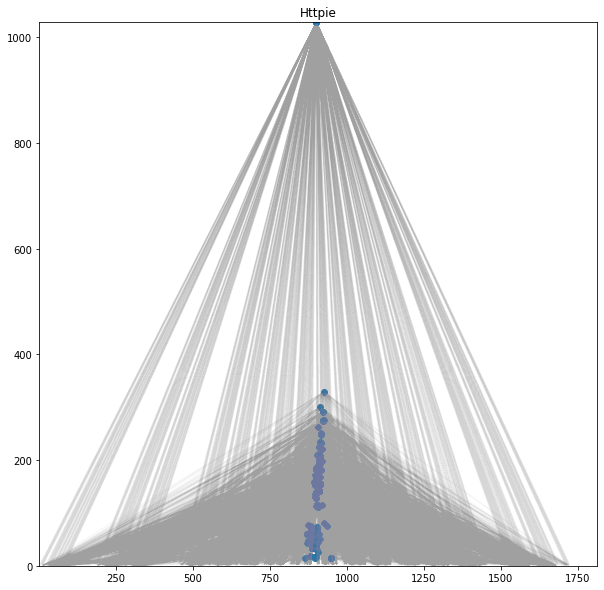

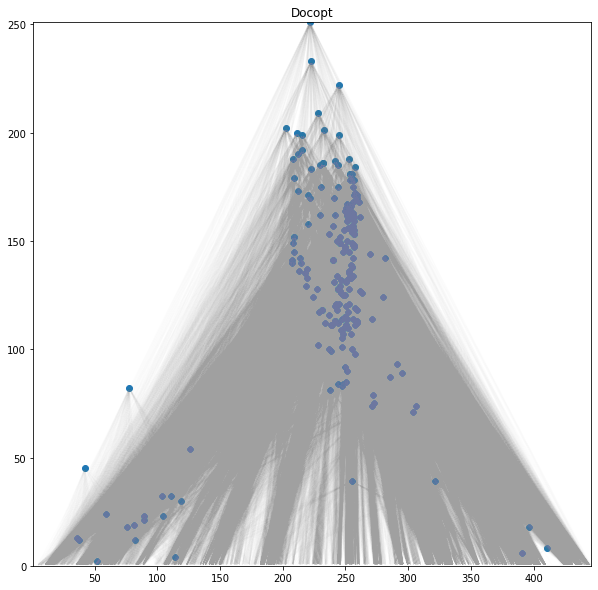

In [7]:
# For larger datasets, this may take a while (~5minutes). You can disable the arrows, then it becomes seconds
for name, mutants_and_tests in datasets.items():
    visualization.plot_hierarchical_failures(name, mutants_and_tests, arrows=True)

# Prediction
## Predicting failing tests

After having a fist visualization the data (and we will continue to do that), the question is if we can train machine learning models to predict failing tests.
While this has obious applications in test selection and reordering, we might also be able to find hidden dependecies in the dataset

## Data Preparation

### Cleansing and Feature Generation

In [8]:
encoded_column_names = ["modified_method", "modified_file_path", "name", "filepath", "current_line", "previous_line"]

encoded_datasets = {}
for name, mutants_and_tests in datasets.items():
    preprocessing.cleanse_data(mutants_and_tests)
    preprocessing.add_edit_distance_feature(mutants_and_tests)
    mutants_and_tests = preprocessing.filter_NaN_values(name, mutants_and_tests)
    encoded_datasets[name] = preprocessing.encode_columns(mutants_and_tests, encoded_column_names)


Flask: Kicked out 45 values from 958041 total values. (0.004697084989058187%) (NaN value filter)
Jinja: Kicked out 145 values from 3624070 total values. (0.004001026470235036%) (NaN value filter)
Httpie: Kicked out 605 values from 322369 total values. (0.18767313234212546%) (NaN value filter)
Docopt: Kicked out 2 values from 95018 total values. (0.0021048643414900425%) (NaN value filter)


The method_name feature seems to make sense from a human perspective: If I change code in the same method, I would expect similar tests to fail.
But to go even further, I tried to add a numerical value, the edit distance between the test name and the method name. The expectation here was, that when both are similar, the test is more likely to fail. You can see examples for that in the [presentation slides, page 40](../presentation/final.pdf)

In the ROC Curve, we can see that if we use the edit_distance as a standalone feature, Httpie and Flask behave better than Jinja and Docopt.
This is interesting, since we have previously seen that both of these projects also had a better distinsting between 'Unit Tests' that test a very specific part of the code, and very few integration tests.

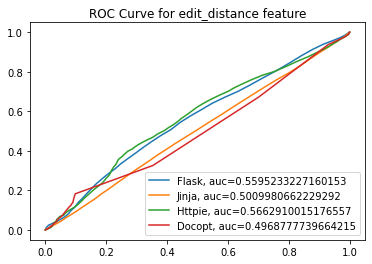

In [9]:
visualization.plot_edit_distance_roc_curve(datasets)

## Feature Selection

We can now select the features we want to use for our predictions.

To be on the save side, we previously drop
* features that could spoil y (`dangerous_features`)
* features that are unencoded (`unencoded_features`)

The features are grouped in three categories:
* Basic features, that are generated with the diff of the mutant, and also test properties
* Semantic features, which are generated from the semantics in the mutant
* Context features, which are gathered in the code around the test and the mutant
See also the [final_presentation_slides, page 37pp](../presentation/final.pdf)

In [10]:
dangerous_features = ['duration', 'setup_outcome', 'setup_duration', 'call_outcome', 'call_duration', 'teardown_outcome', 'teardown_duration']
unencoded_features = ['repo_path', 'full_name']

selected_features = [
    # Basic features:
    'current_line', 'line_number_changed',
    'modified_file_path', 'previous_line', 'test_id',
    'name', 'filepath', 'mutant_id', 'outcome',
    # Semantic features:
    'modified_method', 'edit_distance',
    # Context features:
    'contains_branch_mutant',
    'contains_equality_comparison_mutant', 'contains_loop_mutant',
    'contains_math_operands_mutant', 'contains_loop_execution', 'contains_math_operands_execution',
    'contains_equality_comparison_execution', 'contains_branch_execution'
]
    

for name, mutants_and_tests in encoded_datasets.items():
    encoded_datasets[name] = mutants_and_tests.drop(dangerous_features, axis=1).drop(unencoded_features, axis=1)[selected_features].copy()


In [11]:
test_train_data = {}

for name, mutants_and_tests in encoded_datasets.items():
    test_train_data[name] = preprocessing.train_test_split(mutants_and_tests)

In [12]:
# The training here takes a long time, depending on the model it can go over hours
predictors = {
    'NearestMutant': predictor.NearestMutantPredictor(),
    'KNeighbors': KNeighborsClassifier(n_neighbors=1),
    'DecisionTree': tree.DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(random_state=420),
    'GradientBoosing': GradientBoostingClassifier(random_state=420),
}

fitted_predictors = {}

for dataset_name, mutants_and_tests in encoded_datasets.items():
    X_train, y_train, X_test, y_test = test_train_data[dataset_name]
    fitted_predictors[dataset_name] = {}
    for predictor_name, predictor_instance in predictors.items():
        predictor_instance = copy.deepcopy(predictor_instance)
        predictor_instance.fit(X_train, y_train)
        fitted_predictors[dataset_name][predictor_name] = predictor_instance
        

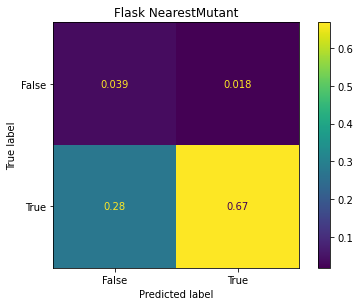

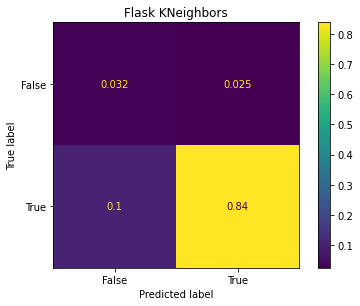

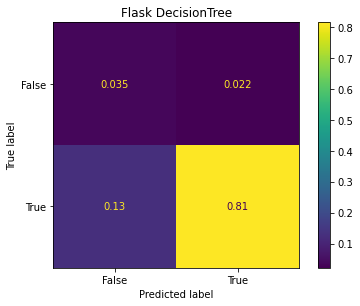

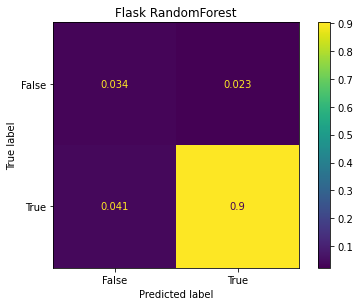

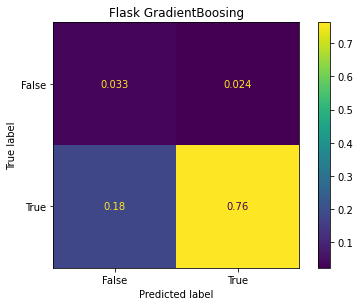

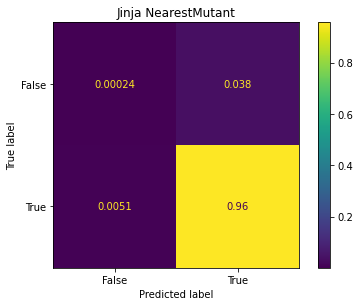

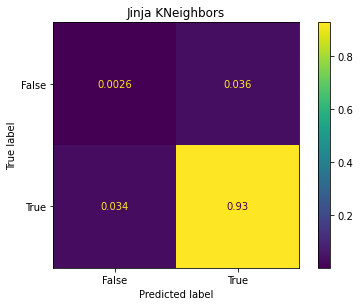

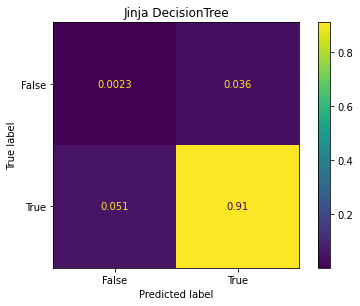

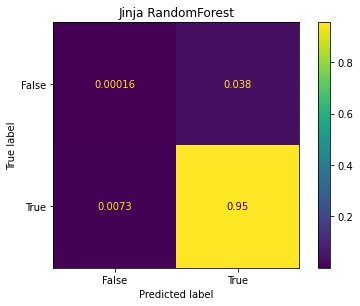

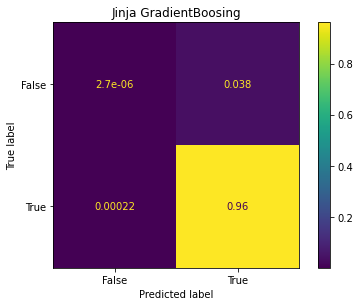

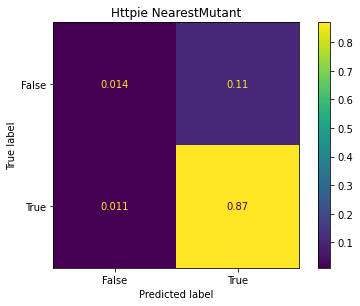

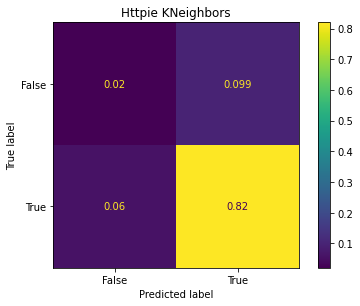

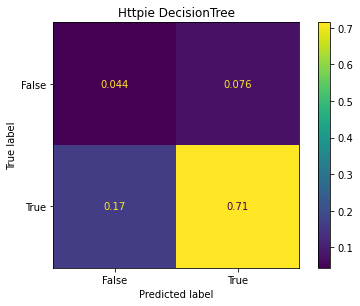

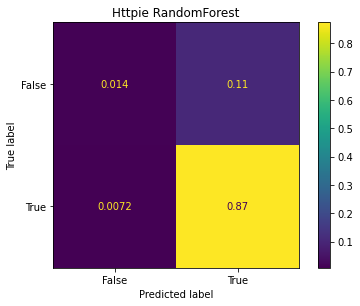

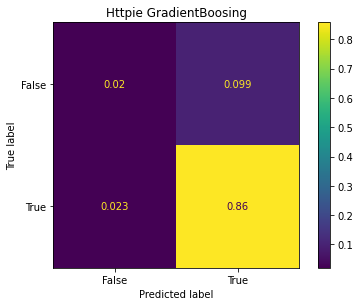

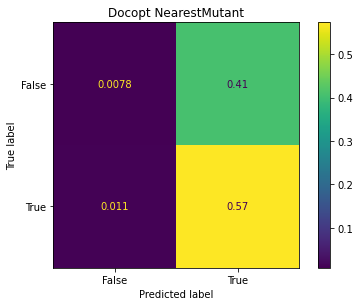

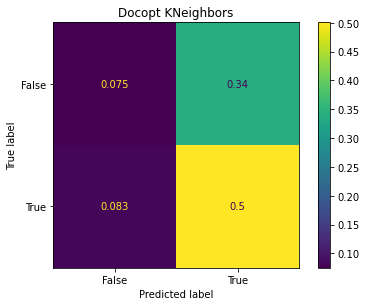

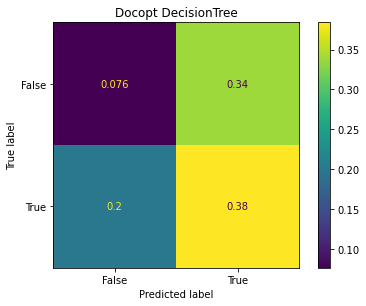

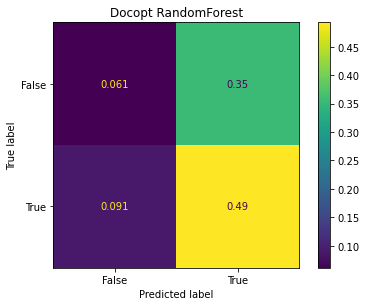

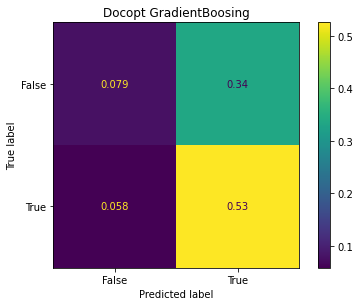

In [13]:
# Splitted visualization
for dataset_name, mutants_and_tests in encoded_datasets.items():
    X_train, y_train, X_test, y_test = test_train_data[dataset_name]
    for predictor_name, predictor_instance in fitted_predictors[dataset_name].items():
        visualization.plot_confusion_matrix(dataset_name + ' ' + predictor_name, predictor_instance, X_test, y_test)
        

We are especially interested in the "True False Predicted False" score, as we can use that to make a good reordering for example. False positives are not too bad in this scenario.

However the true negative rate is really bad overall, only differing slightly between the datasets. This is bad if we want to find test that fail.

To get a glimpse on what the classifiers learn in the dataset, we have a look at the RandomForestClassifier.
One nice thing about this classifier is that we can try to debug it using it's feature importances. These can give us a hint on what the forest uses to decide between a false and true outcome.

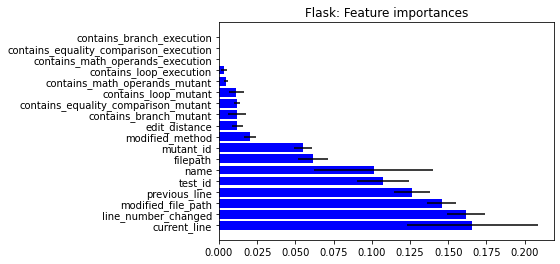

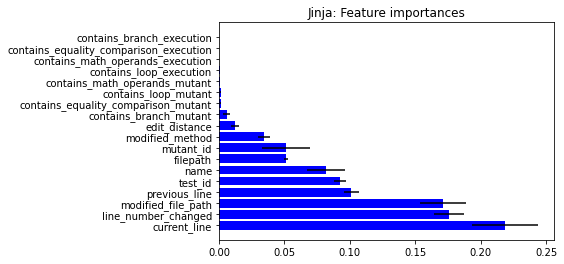

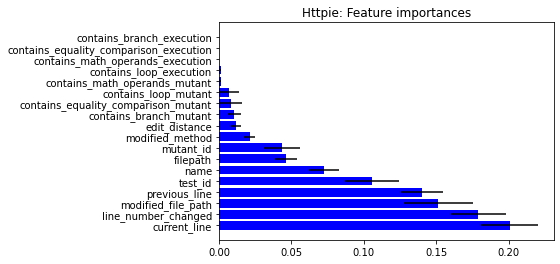

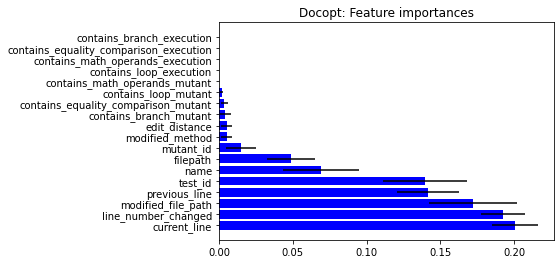

In [14]:
for name, fitted_predictor in fitted_predictors.items():
    visualization.plot_feature_importances(name, fitted_predictor['RandomForest'], test_train_data)

Here we can see that for the Flask and Httpie dataset, the random forest makes more usage of the 'semantic' and 'context' features in the dataset, which might also be an indication that the tests in that project are especially well organized.
It would be an interesting point of research to check wether this can also be perceived by the human as a 'predictable' test suite.

# Reordering

## Reordering the testcases to improve the developer experience

While it is nice to be able to predict which test fail and which not, it is easier to decide if a classification is good or bad based on a concrete use case.
Therefore, the predictors are tested on various metrics in the test case reordering domain.
* APFD, which is a measure on how good a order of tests is in general, but which is duration agnostic
* APFDc, which is APFDc weighted after the average durations of the mentioned tests
* First Failing, which is the time that emerges till a test is found that fails
* Last Failing, which is the time that emerges till the last test that fails is found

There are multiple ways to derive an order for test case execution. To bridge the gap between prediction and reordering, there are 2 main helper classes:
* `BinaryPredictionReorderer`, which takes a binary predictor, and moves the (predicted) failing tests to the front
* `OrdinaryPredictionReorderer`, which sorts the tests ascending after there (predicted) chance of failing

To have some baseline, there are also some mutant agnostic Reorderes. That means that they will output the same order for every mutant:
* `NaiveReorderer`, which just outputs the tests after ascending test_ids
* `AverageReorderer`, which orders the tests after there overall a priori probability to fail
* `QTF`, which is sorting the tests ascending after there duration. It is a heuristic mentioned in [this paper](https://dl.acm.org/doi/pdf/10.1145/3395363.3397383)

The `ReorderingAnalyzer` class can be used to automatically train and evaluate the reorderes, and print boxplots:

In [15]:
# This step takes not only long to train, but also long to evaluate, with a lot of predictors it will take hours. Every 50 orders processed there will be a dot printed,
# so you can get a feelint on how long it will take.

evaluations = {}
for name, mutants_and_tests in encoded_datasets.items():
    evaluation = ReorderingAnalyzer([
        NaiveReorderer(),
        AverageReorderer(),
        QTF(datasets[name][['test_id', 'duration']]),
        BinaryPredictionReorderer(tree.DecisionTreeClassifier()),
        BinaryPredictionReorderer(KNeighborsClassifier()),
        BinaryPredictionReorderer(RandomForestClassifier(random_state=420)),
        OrdinalPredictionReorderer(RandomForestClassifier(random_state=420)),
        BinaryPredictionReorderer(GradientBoostingClassifier(random_state=420)),
        OrdinalPredictionReorderer(GradientBoostingClassifier(random_state=420))
    ])
    X_train, y_train, X_test, y_test = preprocessing.train_test_split(mutants_and_tests)
    evaluation.fit(X_train, y_train)
    evaluation.predict(X_test)
    evaluation_data = evaluation.evaluate(datasets[name])
    evaluations[name] = evaluation


Starting evaluation .......... finished.
Starting evaluation .......... finished.
Starting evaluation .......... finished.
Starting evaluation .......... finished.
Starting evaluation .......... finished.
Starting evaluation .......... finished.
Starting evaluation .......... finished.
Starting evaluation .......... finished.
Starting evaluation .......... finished.
Starting evaluation .............................. finished.
Starting evaluation .............................. finished.
Starting evaluation .............................. finished.
Starting evaluation .............................. finished.
Starting evaluation .............................. finished.
Starting evaluation .............................. finished.
Starting evaluation .............................. finished.
Starting evaluation .............................. finished.
Starting evaluation .............................. finished.
Starting evaluation ..... finished.
Starting evaluation ..... finished.
Starting e

Dataset: Flask


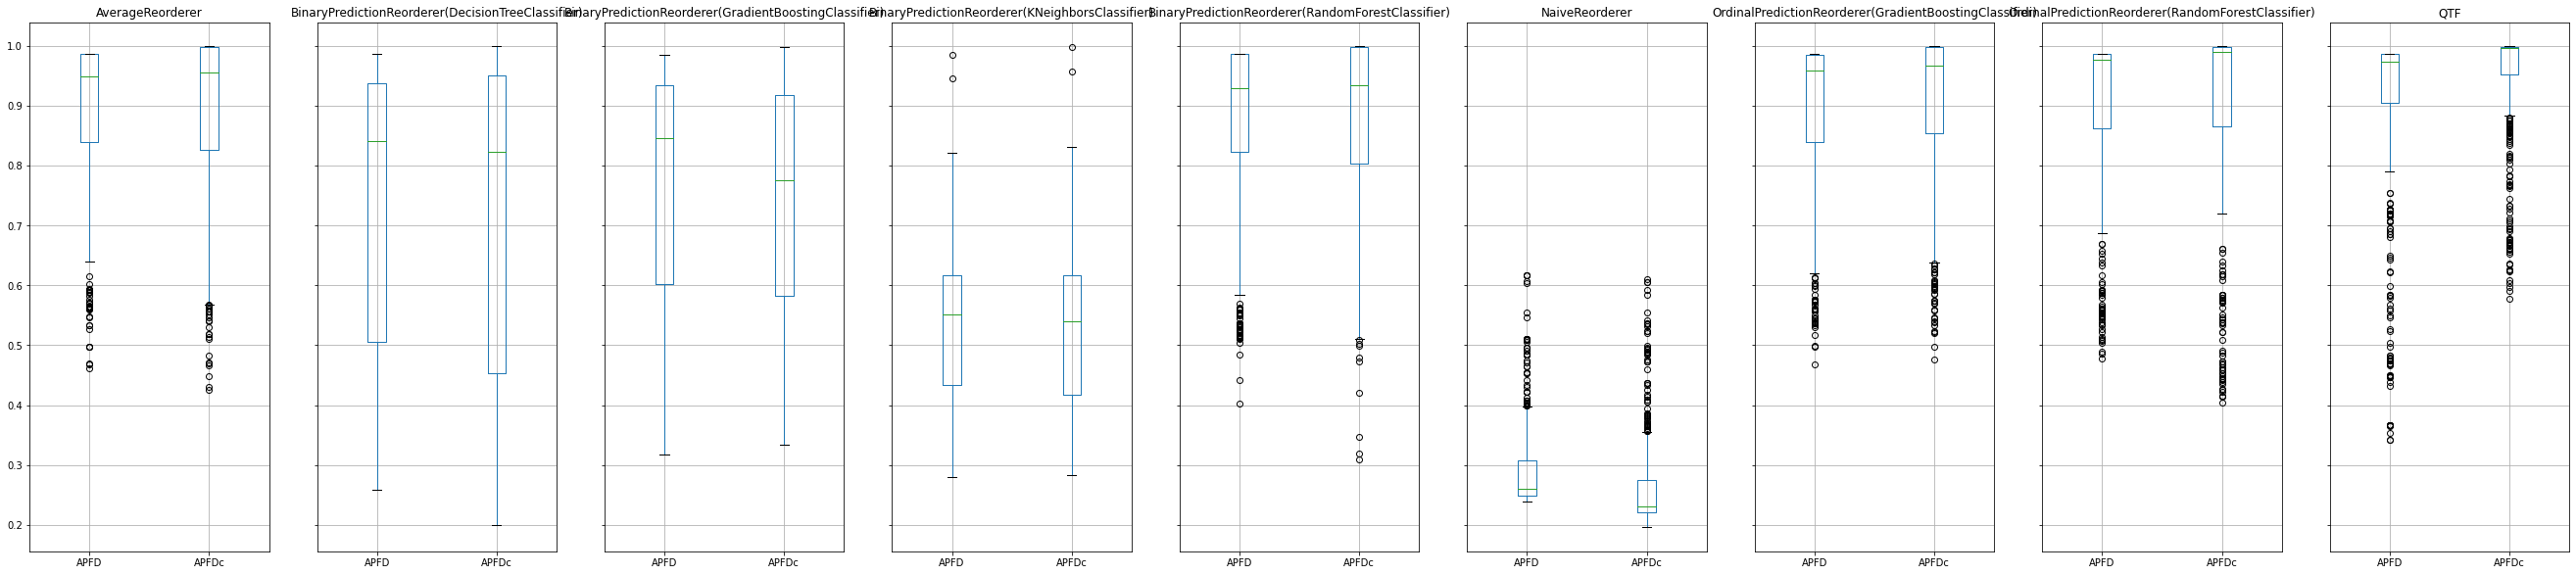

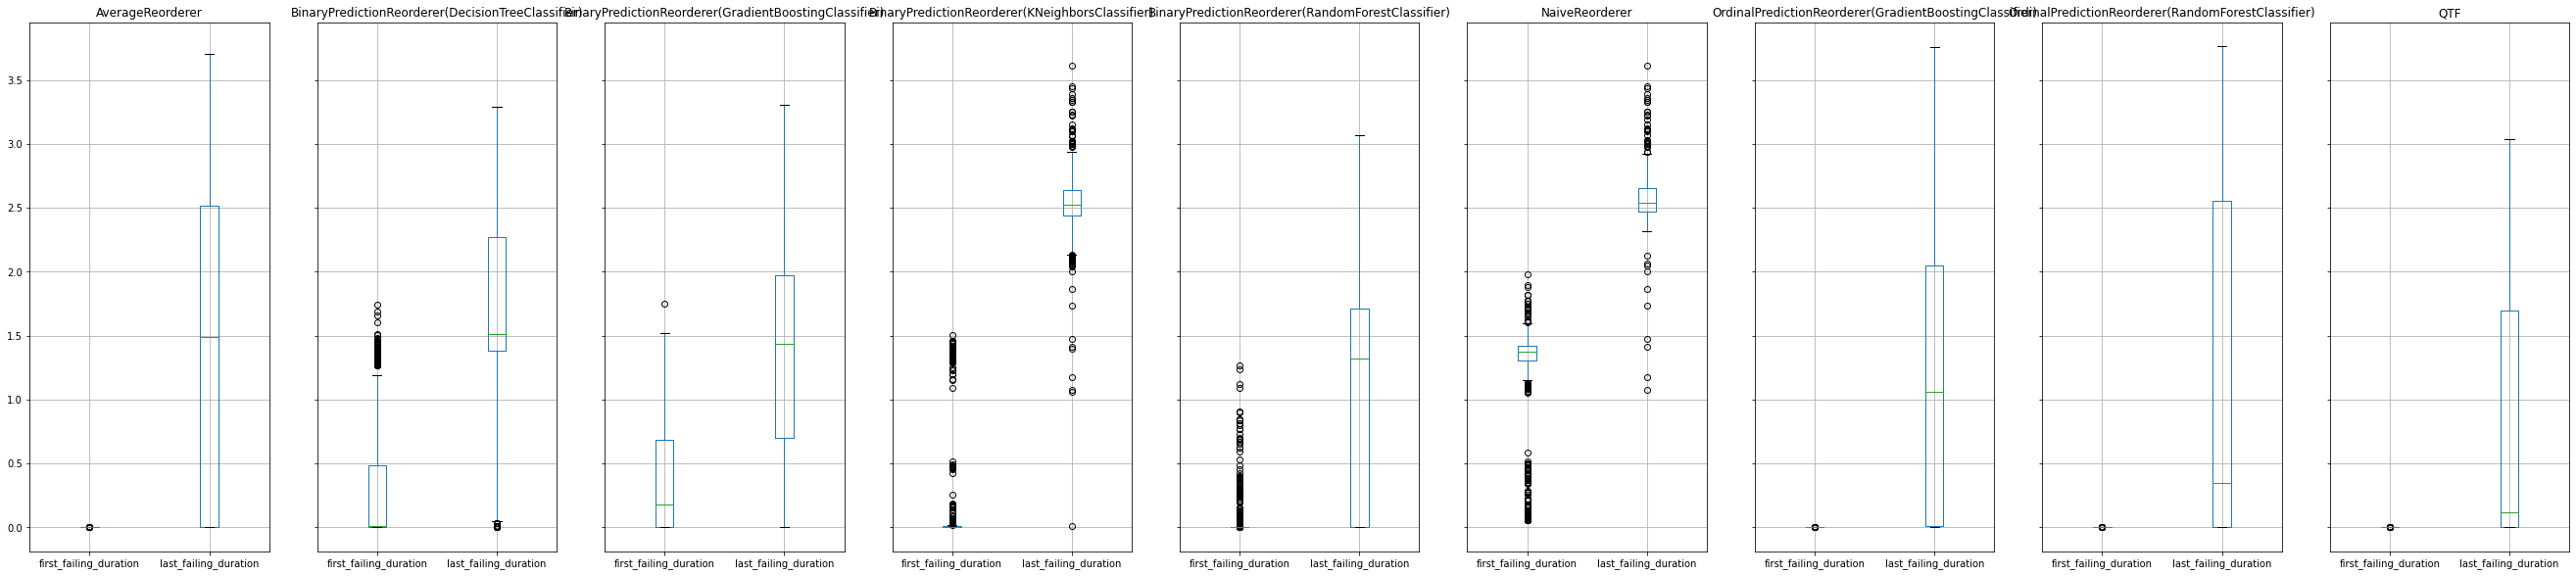

Dataset: Jinja


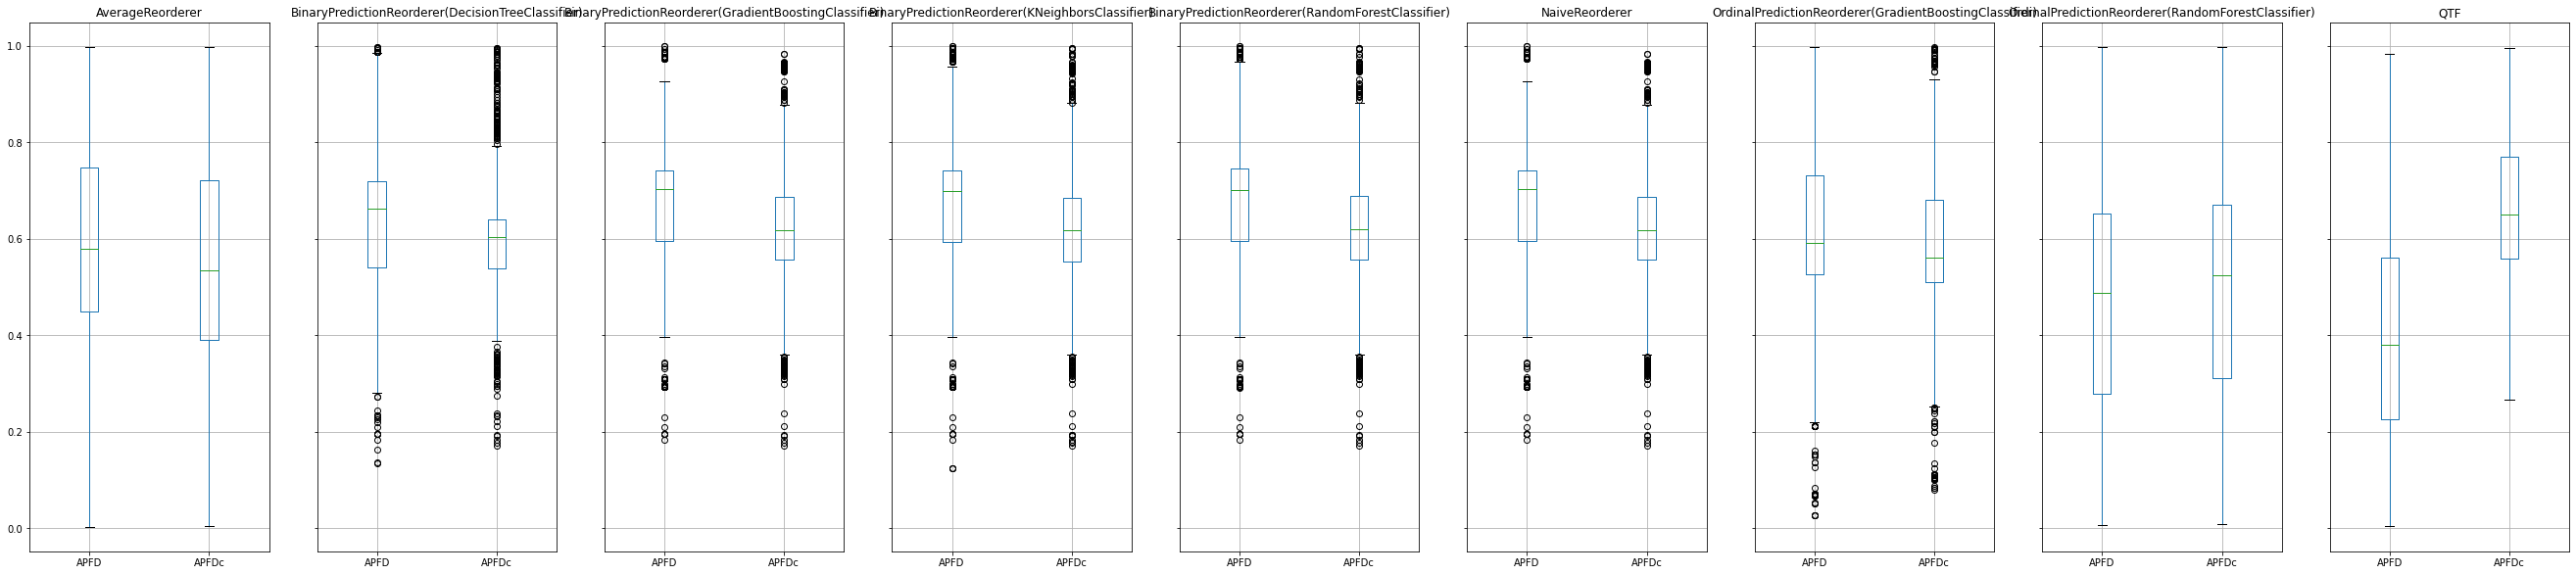

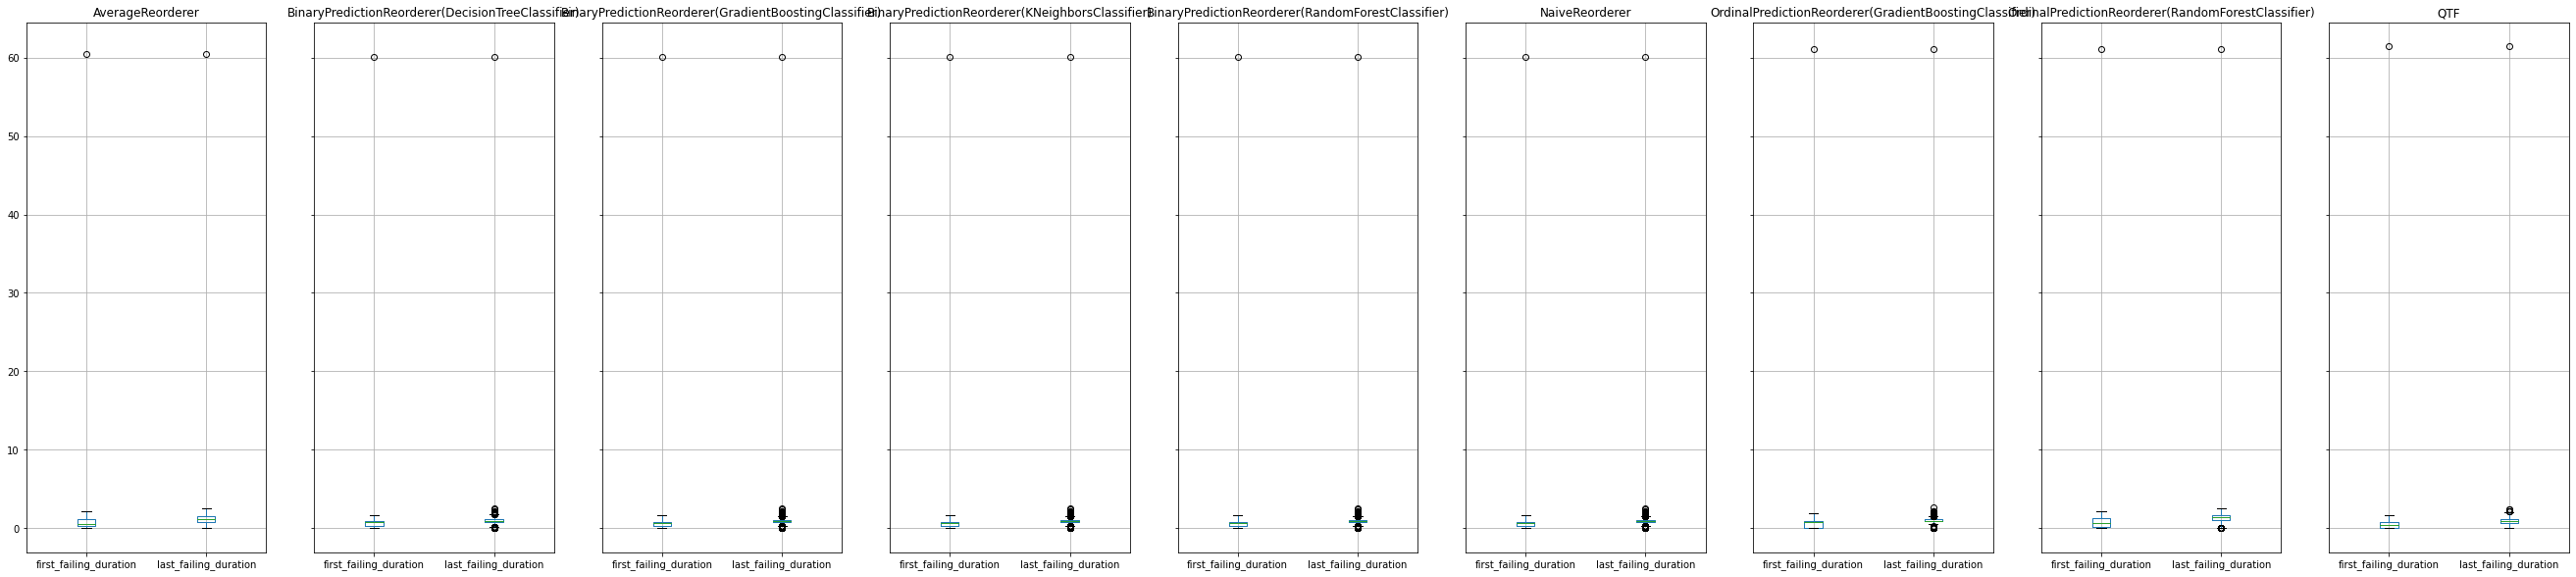

Dataset: Httpie


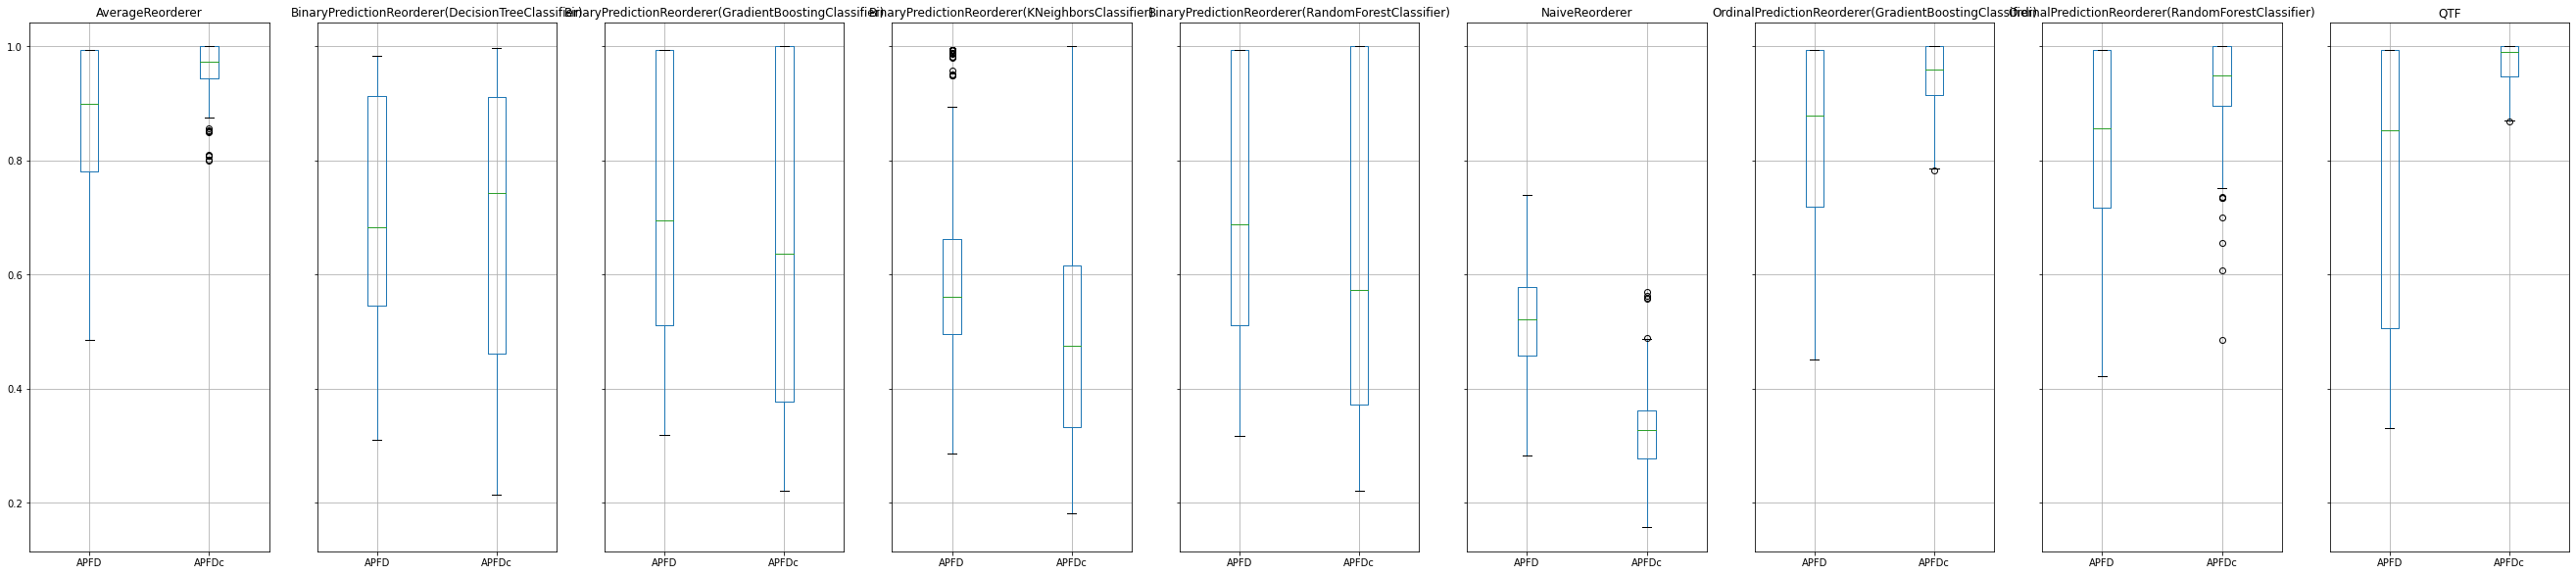

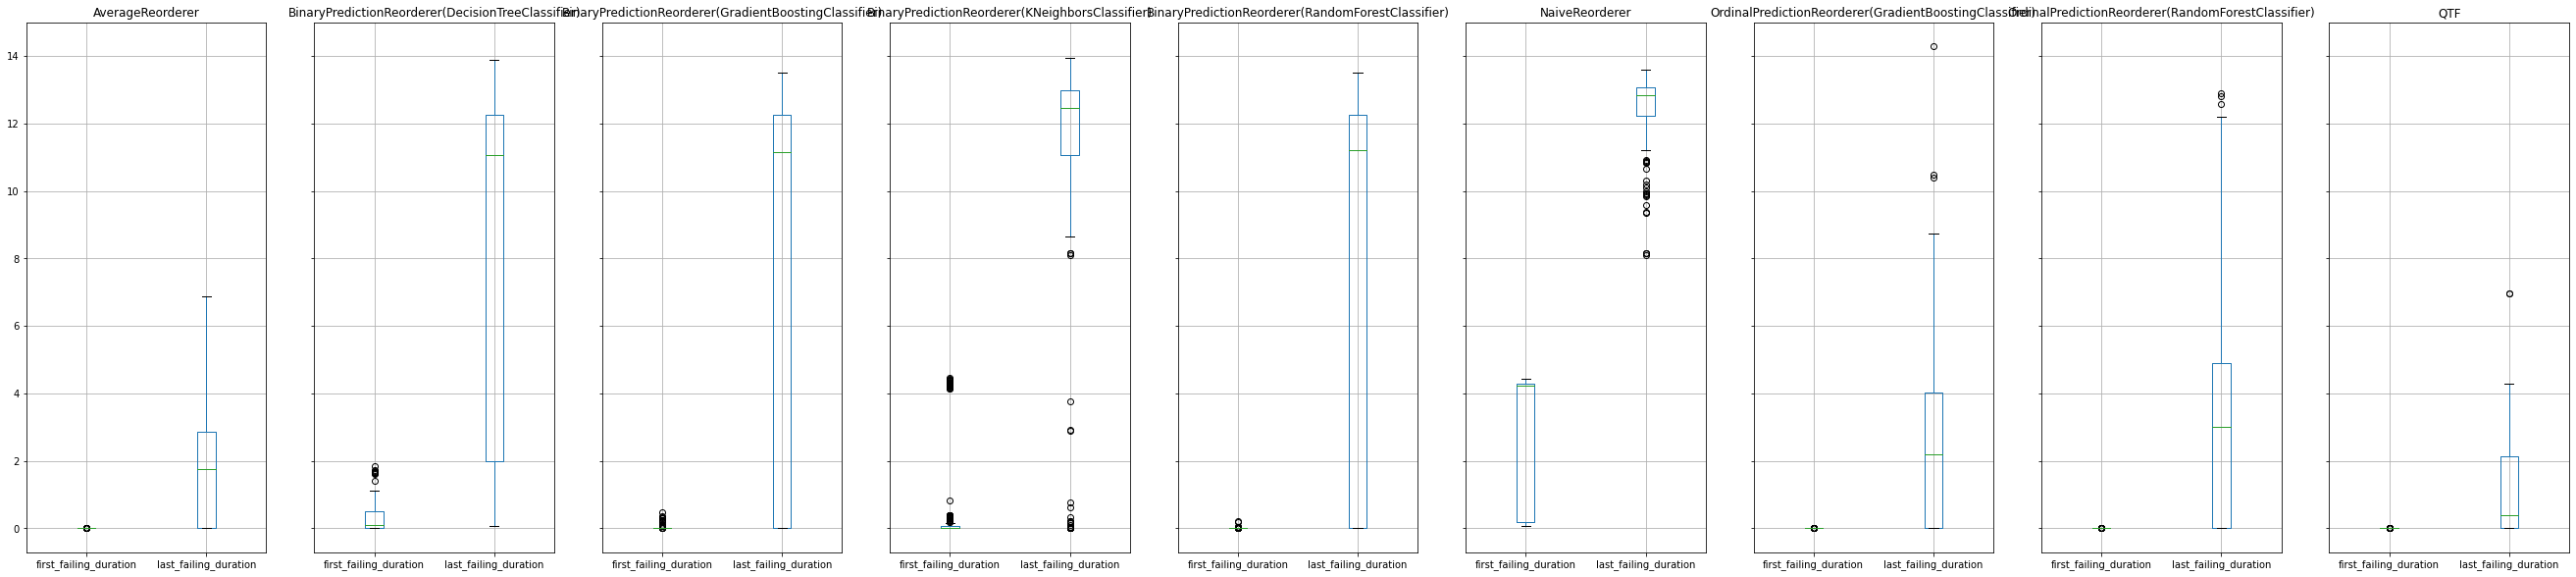

Dataset: Docopt


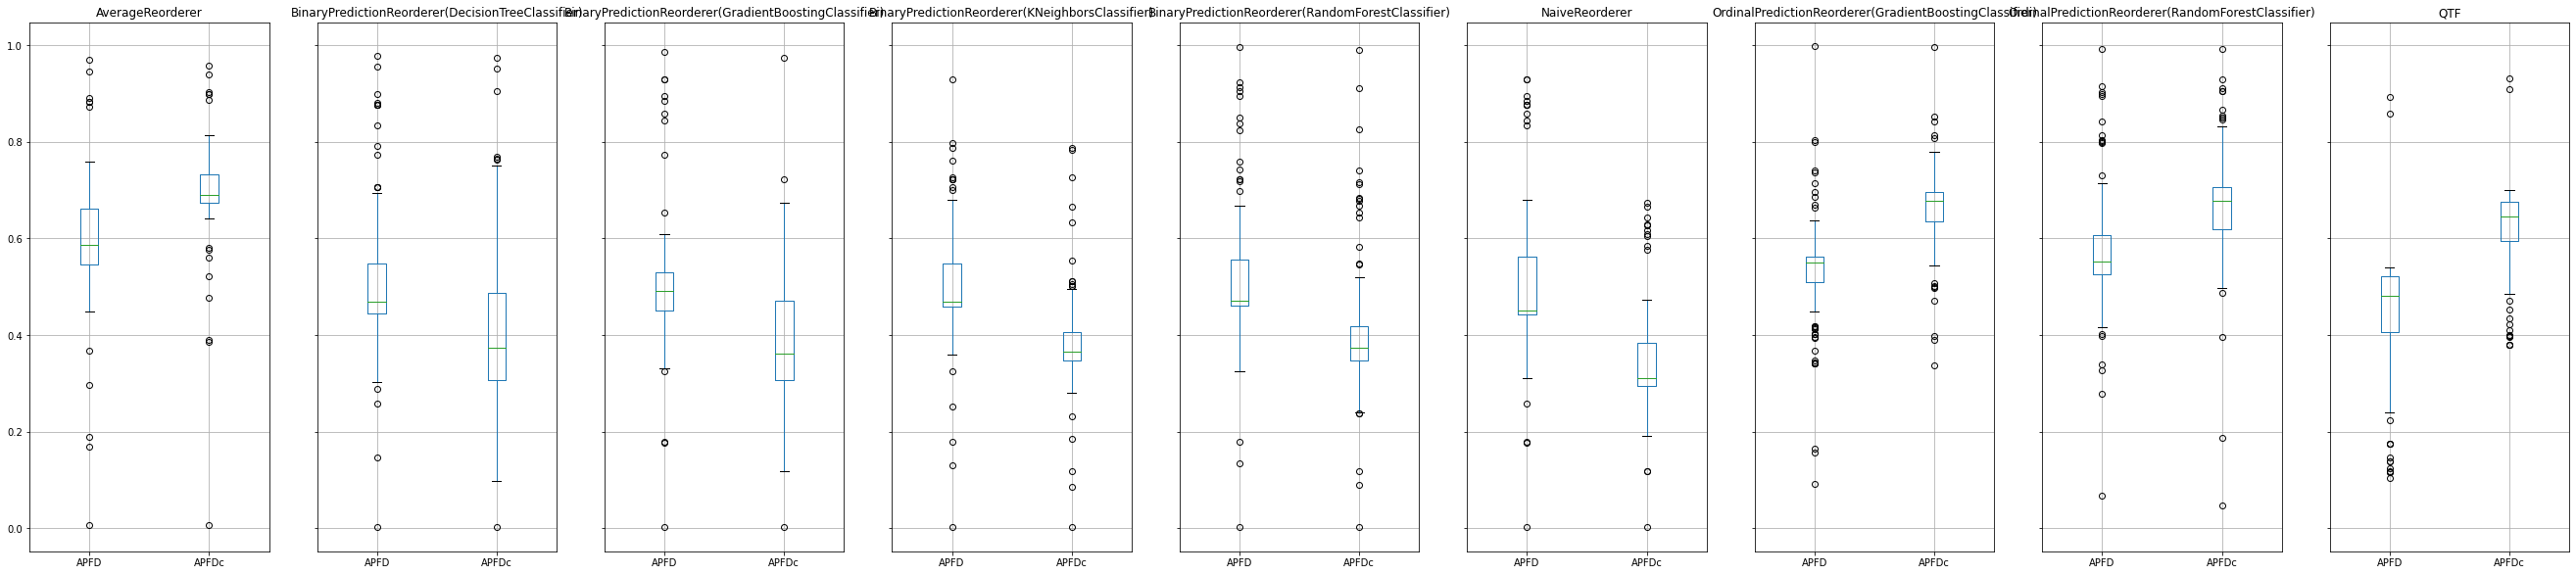

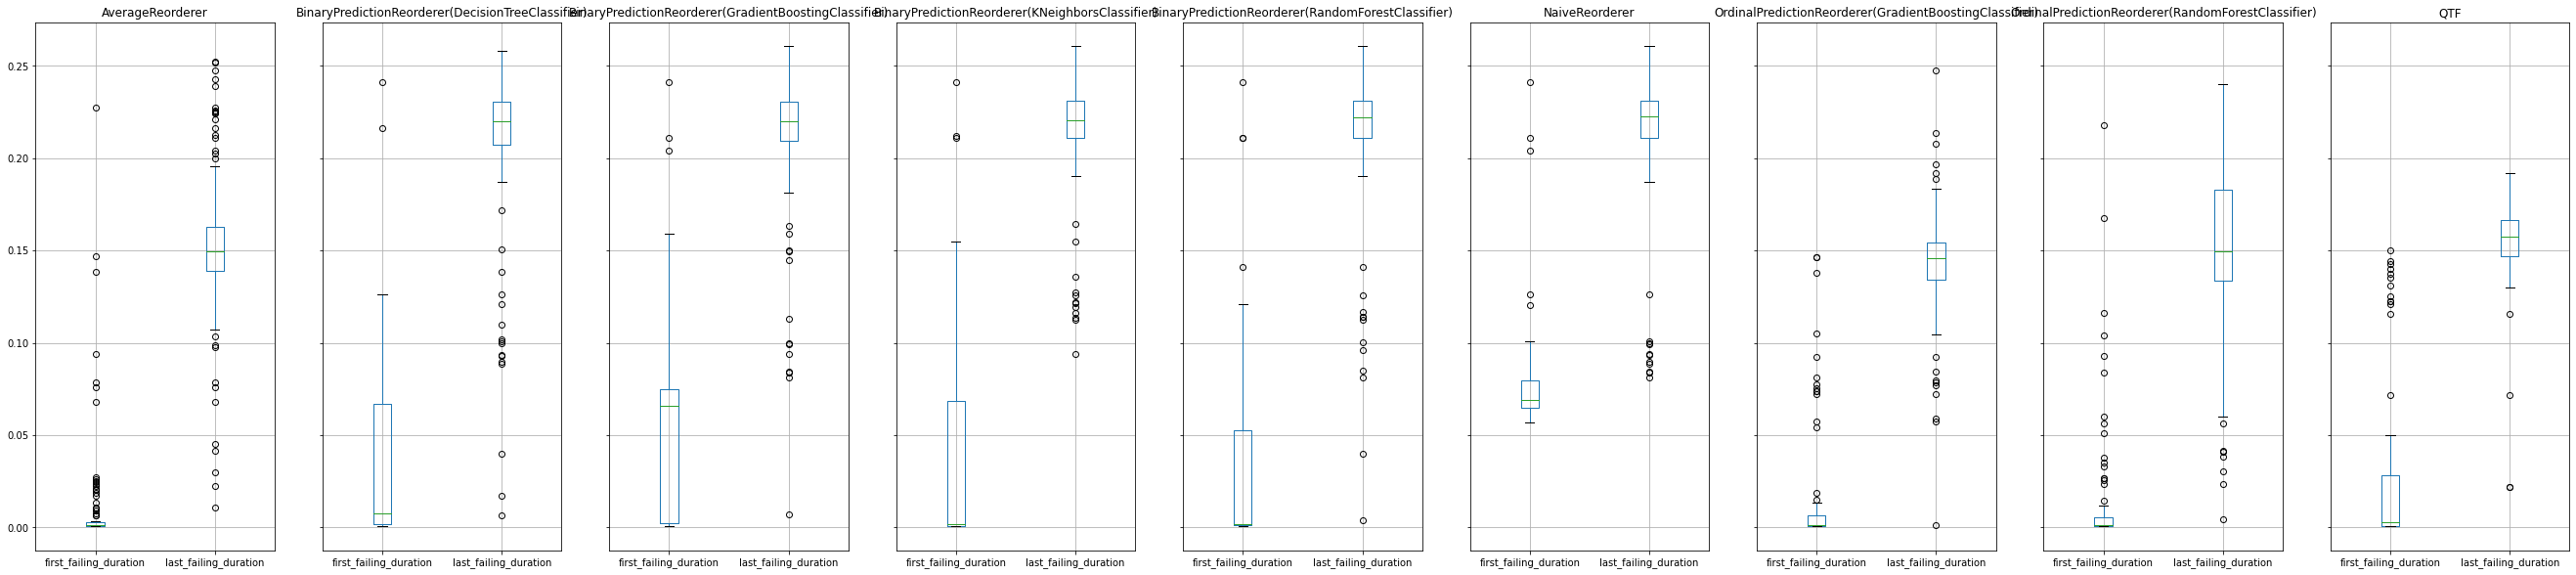

In [17]:
for name, evaluation in evaluations.items():
    print('Dataset: ' + name)
    evaluation.boxplot()
    plt.show()

A first interesting observation is that indeed `QTF` does not perform really bad on any of the datasets, and that even in the duration agnostic APFD measure.

We also see again the phenomena that Flask and Httpie seem to be better predictable, while Jinja and Docopt have overall worse metric scores.

One could definitely use some Hyperparameter-Tuning to improve some of the values seen in the boxplots. Even training based on a reordering instead of a prediction of sole test cases would be possible. This single test prediction approach has however the potential to be also applied in other use cases, for example test case selection, where only a subset of the tests is run.

An interesting aspect could also be the analysis of the outliers for APFD and APFDc seen with all of the datapoints. Do these mutants maybe uncover hidden dependencies in the tests, as they
are really unpredictable? Are the mutants that are hard to reorder the same for the datasets.